In [1]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import sklearn.preprocessing as preprocessing
import statsmodels.api as sm
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

from datetime import datetime
from IPython.display import display
from itertools import combinations
from matplotlib.ticker import MaxNLocator
from math import *
from numpy.testing import assert_almost_equal
from sklearn.decomposition import PCA
from statsmodels.stats.proportion import proportions_ztest

# Custom output options.
np.set_printoptions(precision=3, suppress=True)
pd.set_option('display.precision', 3)
sns.set_style('whitegrid')
sns.set_context('paper')
plt.rcParams['figure.figsize'] = 8, 5 # default 6x4
%matplotlib inline

# default folder to save LaTEX strings with save_df_latex() and to save 
# matplotlib figures.
DF_LATEX_FOLDER = 'FinalLatex\\'

CRYPTO_FILES = [('ripple_price', 'rip'), ('bitcoin_price', 'btc'),
                ('ethereum_price', 'eth'), ('litecoin_price', 'ltc'),
                ('monero_price', 'mon'), ('nem_price', 'nem'),
                ('dash_price', 'dash')]

BSK_FILES = [('AAPL', 'AAPL'), ('GLD', 'GLD'), ('HYG', 'HYG'), 
             ('X', 'X'), ('GE', 'GE'), ('M', 'M'), ('MOS', 'MOS')]

XLE_FILES = [('COP_data', 'COP'), ('CVX_data', 'CVX'),
                ('EOG_data', 'EOG'), ('OXY_data', 'OXY'),
                ('PSX_data', 'PSX'), ('SLB_data', 'SLB'),
                ('XOM_data', 'XOM')]

C:\Users\Nathaniel\Anaconda3\lib\site-packages\statsmodels\compat\pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [2]:
#####################################################################
# Utils used throughout the notebook to read/write data, perform  
# commonly used computations. 
#####################################################################

def load_returns_matrix (files, tdelta=pd.Timedelta(days=30), center=True, 
                         scale=True):
    """Returns cryptocurrency rolling returns for which a price level is 
    available for all the assets.
    
    Args:
        files (list of tuples): (asset name, file path) tuples. Asset name 
            used in column headers for DF.
        
    Returns:
        dfout (DataFrame): Returns without centering/scaling.
        dfout_adj (DataFrame): Returns with centering/scaling (depending 
            on input vals for center and scale).
    """
    dfs = []
    for file, name in files:
        path = 'cryptocurrencypricehistory//{}.csv'.format(file)
        df = pd.read_csv(path, usecols=['Date', 'Close'])
        df['Date'] = pd.to_datetime(df['Date'])
        df = df[['Date', 'Close']]
        df.set_index('Date', drop=True, inplace=True)
        df.rename(columns={'Close':name}, inplace=True)
        dfs.append(df)
    dfout = pd.concat(dfs, axis=1, join='inner')
    first_date = min(dfout.index)
    last_date = max(dfout.index)
    dfout = dfout.pct_change(periods=1, freq=tdelta)
    dfout.dropna(axis=0, how='any', inplace=True)
    xout = preprocessing.scale(dfout, axis=0, with_mean=center, with_std=scale)
    dfout_adj = pd.DataFrame(xout, columns=dfout.columns, index=dfout.index)
    return dfout, dfout_adj


def load_xle_returns (files, tdelta=pd.Timedelta(days=30), center=True, 
                      scale=True, start=None, end=None):
    """Returns top XLE components' rolling returns.
        
    Args:
        files (list of tuples): (asset name, file path) tuples. Asset name 
            used in column headers for DF.
        
    Returns:
        dfout (DataFrame): Returns without centering/scaling.
        dfout_std (DataFrame): Returns with centering/scaling (depending 
            on input vals for center and scale).
    """
    dfs = []
    for file, name in files:
        path = 'XLE//{}.csv'.format(file)
        df = pd.read_csv(path, usecols=['Date', 'Close']).iloc[::-1]
        df['Date'] = pd.to_datetime(df['Date'])
        df = df[['Date', 'Close']]
        df.set_index('Date', drop=True, inplace=True)
        df.rename(columns={'Close':name}, inplace=True)
        dfs.append(df)
    dfout = pd.concat(dfs, axis=1, join='inner')
    dfout = dfout.pct_change(periods=1, freq=tdelta)
    dfout.dropna(axis=0, how='any', inplace=True)
    
    # Filter time frame.
    if start is not None:
        dfout = dfout[dfout.index >= start]
    if end is not None:
        dfout = dfout[dfout.index <= end]
    
    xout = preprocessing.scale(dfout, axis=0, with_mean=center, with_std=scale)
    dfout_std = pd.DataFrame(xout, columns=dfout.columns, index=dfout.index)
    return dfout, dfout_std

def load_other_returns (files, tdelta=pd.Timedelta(days=30), center=True, 
                        scale=True, start=None, end=None):
    """Creates rolling-return DataFrame for assets in files in other_assets 
    folder.
        
    Args:
        files (list of tuples): (asset name, file path) tuples. Asset name 
            used in column headers for DF.
        
    Returns:
        dfout (DataFrame): Returns without centering/scaling.
        dfout_std (DataFrame): Returns with centering/scaling (depending 
            on input vals for center and scale).
    """
    dfs = []
    for file, name in files:
        path = 'other_assets//{}.csv'.format(file)
        df = pd.read_csv(path, usecols=['date', 'close'])
        df['date'] = pd.to_datetime(df['date'])
        df.columns = ['Date', 'Close']
        df.set_index('Date', drop=True, inplace=True)
        df.rename(columns={'Close':name}, inplace=True)
        dfs.append(df)
    dfout = pd.concat(dfs, axis=1, join='inner')
    first_date = min(dfout.index)
    last_date = max(dfout.index)
    dfout = dfout.pct_change(periods=1, freq=tdelta)
    dfout.dropna(axis=0, how='any', inplace=True)
    
    # Filter time frame.
    if start is not None:
        dfout = dfout[dfout.index >= start]
    if end is not None:
        dfout = dfout[dfout.index <= end]
    
    xout = preprocessing.scale(dfout, axis=0, with_mean=center, with_std=scale)
    dfout_std = pd.DataFrame(xout, columns=dfout.columns, index=dfout.index)
    return dfout, dfout_std

def create_proportion_of_variation_df (eigvals):
    total_var = sum(eigvals)
    cols = ['Component', 'Eigenvalue', 'Proportion', 'Cumulative']
    df = pd.DataFrame(columns=cols)
    cum = 0
    for i, e in enumerate(eigvals):
        cum += e
        row = {'Component':i + 1,
               'Eigenvalue':e,
               'Proportion':e/total_var,
               'Cumulative':cum/total_var}
        df = df.append(row, ignore_index=True)
    df['Component'] = df['Component'].astype(int)
    df.set_index('Component', drop=True, inplace=True)
    return df


def create_eigvec_df (eigvecs):
    """Create DataFrame of eigenvectors."""
    idx = [i + 1 for i in range(len(eigvecs))]
    df = pd.DataFrame(index=idx)
    for i, v in enumerate(eigvecs):
        df['V{}'.format(i + 1)] = v
    return df

def get_variation_loadings(df, use_jacobi=False):
    """Computes proportion of variation explained (using eigenvalues) 
    and loadings of column variables on principal components.
    
    Args:
        df (DataFrame): Time series with columns representing assets.
        use_jacobi (bool): Whether to use Jacobi method to compute 
            eigenvalues and eigenvectors. If False, np.linalg.eig will
            be used.
    
    Returns:
        df_variation (DataFrame): Contains eigenvalues and proportion of 
            variation explained.
        df_loadings (DataFrame): Loadings for each principal component 
            on assets. Columns returned may be in different order than 
            they appear in df since they are sorted according to the 
            order of the eigenvalue magnitude.    
    """
    # Retrieve eigenvectors and eigenvalues.
    cov = np.cov(df.values.T)
    if use_jacobi:
        eig_vals, eig_vecs = jacobi(cov, 1e-9)
    else:
        eig_vals, eig_vecs = np.linalg.eig(cov)
    # Create list of (eigenvalue, eigenvector, i) tuples
    # where i represents original ordering (for use in column names).
    eig_pairs = [(np.abs(eig_vals[i]), eig_vecs[:,i], i) 
                 for i in range(len(eig_vals))]
    
    # Sort from high to low, then extract now-sorted eigenvalues and 
    # eigenvectors.
    eig_pairs.sort(key = lambda x: x[0], reverse= True)
    eig_vecs = [epair[1] for epair in eig_pairs]
    eig_vals = np.array([epair[0] for epair in eig_pairs])
    newcol_indxs = [epair[2] for epair in eig_pairs]
    newcols = [df.columns[i] for i in newcol_indxs]
    
    # Create matrix with eigenvectors in columns.
    V = np.column_stack(eig_vecs)
    
    df_variation = create_proportion_of_variation_df(eig_vals)
    loadings = np.multiply(V, np.sqrt(eig_vals)).T
    newcols = [df.columns[e[2]] for e in eig_pairs]
    
    p = len(df.columns) # number of variables
    idx = pd.Series([i + 1 for i in range(p)], name='Component')
    df_loadings = pd.DataFrame(loadings, columns=newcols, index=idx)
    
    return df_variation, df_loadings 

def save_df_latex(df, filename, dec=None, folder=DF_LATEX_FOLDER):
    """Saves DataFrame to Latex in notebook-defined folder."""
    if filename[-4:] != '.txt': filename += '.txt'
    path = DF_LATEX_FOLDER + filename
    if dec is None: s = df.to_latex()
    else: s = df.round(dec).to_latex()
    
    with open(path, "w") as text_file:
        text_file.write(s)
        
def sxn_break(x):
    print(x)
    print('-'*30)

In [3]:
# Jacobi method
# Performs a series of plane rotations to calculate eigenvalues and
# eigenvectors of a matrix, A. Iteratively finds the largest element
# and makes it zero by performing a plane rotation on the rows and columns
# where the largest element is located.
#
# Return:
# Returns eigenvalues for matrix A and the corresponding eigenvectors.
def jacobi(A,tol = 1.0e-9): # Jacobi method
    
    # Finds largest element and its indexes above the diagonal:
    def getMax(A):
        maxVal = 0.0
        # Only need to check upper triangle of matrix:
        for i in range(len(A)-1):
            for j in range(i+1,len(A)):
                if abs(A[i,j]) >= maxVal:
                    maxVal,k,l = abs(A[i,j]),i,j
        return maxVal,k,l
    
    # Performs one plane rotation to eliminate the largest element
    # that is not on the diagonal.
    # Input:
    # A: square matrix that is initially the covariance matrix
    # P: the eigenvector matrix that is initally the identity matrix
    #
    # Output (does not return the variables; changes by reference):
    # A: has the eigenvalues on the diagonal
    # P: stores the eigenvectors
    # rotCount: stores how many rotations were performed:
    def rotate(A,P,rotCount):
        
        # Performs a rotation at locations (i,j) and (k,l) in matrix M:
        # M : the matrix to perform rotation on
        # i,j: location of first element to rotate
        # k,l: location of second element to rotate
        def rotatePair(M,i,j,k,l):
            M_ij,M_kl = M[i,j],M[k,l]
            
            M[i,j] = M_ij - s*(M_kl+M_ij*tau)
            M[k,l] = M_kl + s*(M_ij-M_kl*tau)
        
        # Size of matrix:
        n = len(A)
        
        # Get indexes of max element:
        maxVal,i,j = getMax(A)
        
        # Matrix has converged if the maximum non-diagonal value is less than epsilon
        # If we have performed 5*n^2 rotations and the matrix has not converged we return:
        if maxVal < tol or rotCount==5*n**2:
            return
        
        # Variables used for rotation:
        theta = (A[j,j]-A[i,i])/(2*A[i,j])
        t = np.sign(theta)/(abs(theta) + sqrt(theta**2 + 1.0))
        c = 1.0/sqrt(1.0 + t**2);
        s = t*c
        tau = s/(1.0 + c)
        
        # Rotation point and it's projection points on the diagonal:
        A_ij = A[i,j]
        
        # Case i)
        A[i,j] = 0.0
        
        # Case ii)
        A[i,i] = A[i,i]-t*A_ij
        A[j,j] = A[j,j]+t*A_ij
        
        # Case iii)
        # Rotation of elements:
        # Combines types of rotations (see picture in PDF):
        
        for r in range(i): # i)   r < i
            rotatePair(A,r,i,r,j)
        for r in range(i+1,j): # ii)  i < r < j
            rotatePair(A,i,r,r,j)
        for r in range(j+1,n): # iii) j < r
            rotatePair(A,i,r,j,r)
        
        # Update eigenvector matrix:
        for r in range(n):
            rotatePair(P,r,i,r,j)
        
        # Iterate until matrix converges:
        rotate(A,P,rotCount+1)
    
    # Initialize the eigenvector matrix:
    n,P,rotCount = len(A), np.identity(len(A))*1.0,0
    
    # Rotate until the matrix has converged:
    rotate(A,P,rotCount)
    
    if rotCount == 5*n**2:
        print('The Jacobi method did not converge')
    
    P[:,2],P[:,3],P[:,6] = -P[:,2],-P[:,3],-P[:,6] # Match order of built in package

    return np.diagonal(A),P

## Cryptocurrency returns analysis

In [4]:
# Init data and obtain covariance matrix.
cryp_unadj, cryp_std = load_returns_matrix(CRYPTO_FILES)

analysis_start_dt = min(cryp_std.index)
analysis_end_dt = max(cryp_std.index)

# Proportion of variation explained and loadings.
cryp_variation, cryp_loadings = get_variation_loadings(cryp_std)

# Are cryptocurrencies an asset class?

## Taking a look at energy (XLE) and a random basket

In [5]:
#####################################################################
# Load reference datasets and filter to be in same time frame as 
# cryptos. Compute their proportion-of-variations and loadings.
#####################################################################

USE_SAME_TIMEFRAME_AS_CRYPTO = True

if USE_SAME_TIMEFRAME_AS_CRYPTO:
    start_date, end_date = analysis_start_dt, analysis_end_dt
else:
    start_date, end_date = None, None
    
# Load energy and basket returns data.
XLE_df, XLE_df_std = load_xle_returns(XLE_FILES, start=start_date, end=end_date)
bsk_df, bsk_df_std = load_other_returns(BSK_FILES, start=start_date, end=end_date)

# Limit both DFs to overlapping time frames if we're not limiting them 
# to crypto time frame.
if not USE_SAME_TIMEFRAME_AS_CRYPTO:
    common_idx = XLE_df.index.intersection(bsk_df.index)
    XLE_df, XLE_df_std = XLE_df.loc[common_idx], XLE_df_std.loc[common_idx]
    bsk_df, bsk_df_std = bsk_df.loc[common_idx], bsk_df_std.loc[common_idx]
        
xle_variation, xle_loadings = get_variation_loadings(XLE_df_std)
bsk_variation, bsk_loadings = get_variation_loadings(bsk_df_std)

### Proportion of variation explained & loadings

In [12]:
sxn_break('Proportion of variation')
print('XLE')
display(xle_variation.round(3))
print('\nBasket')
display(bsk_variation.round(3))

sxn_break('\nLoadings')
print('XLE')
display(xle_loadings.round(3))
print('\nBasket')
display(bsk_loadings.round(3))

save_df_latex(xle_loadings, 'XLE loadings', dec=3)
save_df_latex(bsk_loadings, 'Basket loadings', dec=3)

Proportion of variation
------------------------------
XLE


Eigenvalue  Proportion  Cumulative
Component                                    
1               4.642       0.661       0.661
2               0.842       0.120       0.781
3               0.549       0.078       0.859
4               0.476       0.068       0.927
5               0.227       0.032       0.959
6               0.175       0.025       0.984
7               0.113       0.016       1.000


Basket


Eigenvalue  Proportion  Cumulative
Component                                    
1               2.651       0.377       0.377
2               1.181       0.168       0.546
3               1.051       0.150       0.695
4               0.822       0.117       0.812
5               0.633       0.090       0.902
6               0.396       0.056       0.959
7               0.289       0.041       1.000


Loadings
------------------------------
XLE


COP    CVX    EOG    OXY    XOM    SLB    PSX
Component                                                 
1          0.772  0.886  0.870  0.854  0.663  0.841  0.793
2          0.426  0.016  0.096 -0.367  0.559 -0.186 -0.413
3         -0.240 -0.374  0.261  0.159  0.142  0.370 -0.318
4         -0.359  0.007 -0.241 -0.016  0.478 -0.021  0.245
5         -0.022 -0.136  0.205  0.200  0.048 -0.347  0.062
6          0.159 -0.089 -0.263  0.254  0.037  0.007 -0.079
7          0.123 -0.225 -0.001 -0.102  0.000  0.055  0.184


Basket


AAPL      X      M    MOS     GE    HYG    GLD
Component                                                 
1         -0.349 -0.135 -0.694 -0.861 -0.491 -0.599 -0.829
2         -0.776  0.512 -0.346  0.132  0.024  0.413  0.084
3         -0.269 -0.733 -0.366  0.087  0.533  0.015  0.122
4         -0.113  0.369  0.159 -0.123  0.589 -0.534  0.018
5         -0.385 -0.183  0.269  0.039 -0.345 -0.341  0.377
6          0.183  0.114 -0.396  0.297 -0.103 -0.254  0.171
7          0.108  0.048 -0.118 -0.362  0.016  0.088  0.349

## Proportion z-test

In [7]:
def count_same_sign(df, column_pair, n_comp):
    """Computes number of times loadings are of the same sign for pair of 
    assets among n_comp components.
    
    Args:
        df (DataFrame): Contains loadings for each asset against component 
            number (index). Assumes that the loadings for the first 
            component are in the first row, the second component the second
            row, etc.
        column_pair (Sequence of length 2): Contains pair of column names 
            for assets whose loadings we want to compare.
        n_comp (int): Number of components to compare the two assets on.
    
    Returns:
        ss_count (int): Number of times loadings are of the same sign.
    """
    ss_count = 0
    x1, x2 = column_pair
    for i in range(n_comp):
        loadings = [df.iloc[i][x1], df.iloc[i][x2]]
        signs = [int(s) for s in np.sign(loadings)]
        if abs(sum(signs)) == 2:
            ss_count += 1
    return ss_count

In [8]:
# Perform proportion z-test using proportion of times the crypto pair 
# had the same loading signs.

def get_same_sign_count_df(df_loadings, ncomp):
    asset_pairs = list(combinations(df_loadings.columns, 2))
    data_rows = []
    for pair in asset_pairs:
        count = count_same_sign(df_loadings, pair, n_comp=ncomp)
        data_rows.append([pair[0], pair[1], count])
    cols = ['Asset 1', 'Asset 2', 'Same Sign Loading']
    df = pd.DataFrame(data_rows, columns=cols)
    return df

def perform_proportion_ztest(ss_df, ncomp, null_hypo_value = 0.5):
    """Performs proportion z-test on DF containing number of same-sign pairs.
    
    Args:
        ss_df (DataFrame): Contains same 'Same Sign Loading' results for 
            asset pair combinations.
        n_comp (int): Number of components the assets were compared on.
        null_hypo_value (float): Proportion of same-sign loadings assumed 
            for null hypothesis.
    
    Returns:
        zstat, pval (floats): Results of proportions_ztest().
    """    
    ss_counts = ss_df['Same Sign Loading'].tolist()
    total_same_sign = sum(ss_counts)
    total_obs = ncomp * len(ss_df.index)
    return proportions_ztest(total_same_sign, 
                             nobs=total_obs, 
                             value=null_hypo_value,
                             alternative='larger', 
                             prop_var=null_hypo_value)

In [9]:
# Prepare DataFrame storing number of times the loadings for a pair of 
# assets have the same signs for a certain number of PCs.

# Number of components to check loadings for.
ss_ncomp_cryp = 5
ss_ncomp_xle = 4
ss_ncomp_bsk = 5

cryp_ss_df = get_same_sign_count_df(cryp_loadings, ss_ncomp_cryp)
xle_ss_df = get_same_sign_count_df(xle_loadings, ss_ncomp_xle)
bsk_ss_df = get_same_sign_count_df(bsk_loadings, ss_ncomp_bsk)

# Conduct tests for each set of assets and store results in DF.
proptest_results = []

# Cryptos
zstat, pval = perform_proportion_ztest(cryp_ss_df, ss_ncomp_cryp)
prop_var = cryp_variation.at[ss_ncomp_cryp, 'Cumulative']
proptest_results.append([ss_ncomp_cryp, zstat, pval, prop_var])

# Energy
zstat, pval = perform_proportion_ztest(xle_ss_df, ss_ncomp_xle)
prop_var = xle_variation.at[ss_ncomp_xle, 'Cumulative']
proptest_results.append([ss_ncomp_xle, zstat, pval, prop_var])

# Basket
zstat, pval = perform_proportion_ztest(bsk_ss_df, ss_ncomp_bsk)
prop_var = bsk_variation.at[ss_ncomp_bsk, 'Cumulative']
proptest_results.append([ss_ncomp_bsk, zstat, pval, prop_var])

proptest_results = np.array(proptest_results).T
proptest_results = pd.DataFrame(
    proptest_results, columns=['Crypto', 'Energy', 'Basket'],
    index=['Components', '$z$', '$p$-value', '$\sigma^2$'])

display(proptest_results)
#save_df_latex(proptest_results, 'proportion test results', dec=3)

Crypto  Energy  Basket
Components   5.000   4.000   5.000
$z$          1.659   1.309   1.269
$p$-value    0.049   0.095   0.102
$\sigma^2$   0.900   0.927   0.902

## Inter-temporal consistency of covariance matrix

*Fit regression model to forecast loadings in time period 2 based on time period 1.*

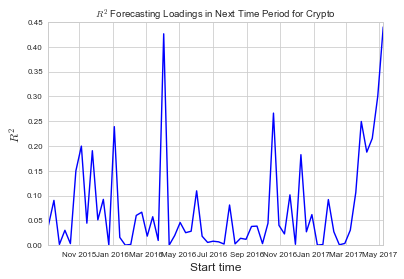

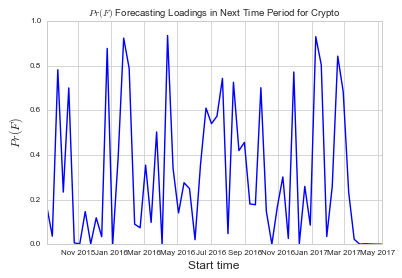

In [10]:
#####################################################################
# Model params.

SAVE_TIMETEST_FIGS = False
TT_ASSET = 'Crypto'
df_tt = cryp_unadj.copy()  # DF of UNSTANDARDIZED asset returns to model

ncomp = 1  # number of components from which to use loadings
ndays = 90  # size of time periods
tstep = 10  # number of rows to jump in setting next time period 1
last_i = len(df_tt.index) - 2*ndays + 1
time_results = []

####################################################################
# Run model.

for i in range(0, last_i, tstep):
    idx1 = i + ndays
    
    # First time period DF.
    df_t1 = df_tt.iloc[i:idx1]
    X_t1 = preprocessing.scale(df_t1, axis=0, with_mean=True, with_std=True)
    df_t1_std = pd.DataFrame(X_t1, columns=df_t1.columns, index=df_t1.index)
    _, loadings_t1 = get_variation_loadings(df_t1_std)
    
    # Second time period DF.
    df_t2 = df_tt.iloc[idx1:idx1+ndays-1]
    X_t2 = preprocessing.scale(df_t2, axis=0, with_mean=True, with_std=True)
    df_t2_std = pd.DataFrame(X_t2, columns=df_t2.columns, index=df_t2.index)
    _, loadings_t2 = get_variation_loadings(df_t2_std)
    
    # Prepare regression data.
    df_x = pd.DataFrame()
    df_x['t1_load'] = np.ravel(loadings_t1.values)
    df_x['intercept'] = 1
    Y = np.ravel(loadings_t2.values)
    model = sm.OLS(Y, df_x).fit()
    results = [df_tt.iloc[i].name, model.rsquared, model.f_pvalue]
    time_results.append(results)

####################################################################
# Plot results.

x = [t[0] for t in time_results]

# R-squared.
y = [t[1] for t in time_results]
plt.xlabel('Start time', fontsize=12)
plt.ylabel('$R^2$', fontsize=12)
plt.title('$R^2$ Forecasting Loadings in Next Time Period for {}'.format(TT_ASSET))
plt.plot(x, y)
plt.show()
if SAVE_TIMETEST_FIGS:
    path = '{}//{} R2 {}D.png'.format(DF_LATEX_FOLDER, TT_ASSET, ndays)
    plt.savefig(path, bbox_inches='tight')

# Prob(F).
y = [t[2] for t in time_results]
plt.xlabel('Start time', fontsize=12)
plt.ylabel('$Pr(F)$', fontsize=12)
plt.title('$Pr(F)$ Forecasting Loadings in Next Time Period for {}'.format(TT_ASSET))
plt.plot(x, y)
plt.show()
if SAVE_TIMETEST_FIGS:
    path = '{}//{} F {}D.png'.format(DF_LATEX_FOLDER, TT_ASSET, ndays)
    plt.savefig(path, bbox_inches='tight')